In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [46]:
analysis_df = pd.read_csv("./Data/check_fraud.csv", low_memory=False)

In [71]:
analysis_df.shape

(307664, 615)

In [48]:
#pull out approved volume to fit and validate the models on
approve_vol = analysis_df[(analysis_df['RC4_AUTH_IND'] == 'A') & ((analysis_df['DUP_PRES_IND'] == 1) | (analysis_df['LOSS_IND'] == -1))]
approve_vol.drop(columns = 'RC4_AUTH_IND', inplace = True)
approve_vol.groupby(['DUP_PRES_IND','LOSS_IND']).count()

,,TXN_UID,FACE_AMOUNT,NAT_POSITIVE_GRADE,SEGMENT,char_CHECK_NO,ID_STATION_STATE,LOCAL_HOUR,DAY_OF_WEEK,AGE,MOD_FACE_AMT,...,C_R_AV_APP_D_12M_14D_RT,C_R_AV_APP_D_6M_7D_RT,C_R_DLY_APPR_24M_14D_RT,C_R_DLY_APPR_12M_14D_RT,C_R_DLY_APPR_6M_3M_RT,C_STD_C_AVG_TIME_24M_RT,C_STD_C_AVG_TIME_6M_RT,C_STD_C_AVG_TIME_30D_RT,C_STD_C_AVG_TIME_18D_RT,C_STD_C_AVG_TIME_14D_RT
DUP_PRES_IND,LOSS_IND,,,,,,,,,,,,,,,,,,,,,
-1,-1,250000,250000,164837,250000,250000,250000,250000,250000,247134,250000,...,217937,206962,231899,217937,155036,219757,183641,115755,69038,55431
1,1,2615,2615,701,2615,2615,2615,2615,2615,2571,2615,...,1839,1582,2149,1839,1034,1880,1173,506,320,250


In [49]:
#pull out target var, in this case 0 = good, 1 = other fraud, 2 = duplicate presentment
y_train = approve_vol[approve_vol['SEGMENT'] == 'DEV'].DUP_PRES_IND
y_val = approve_vol[approve_vol['SEGMENT'] == 'VDT'].DUP_PRES_IND

X_train = approve_vol[approve_vol['SEGMENT'] == 'DEV'].drop(columns = ['TXN_UID','SEGMENT','DUP_PRES_IND','LOSS_IND'])
X_val = approve_vol[approve_vol['SEGMENT'] == 'VDT'].drop(columns = ['TXN_UID','SEGMENT','DUP_PRES_IND','LOSS_IND'])

#I also need a data frame of all transactions, including declines, that I can score for deeper analysis
X_deep_dive = analysis_df.drop(columns = ['TXN_UID','SEGMENT','DUP_PRES_IND','LOSS_IND','RC4_AUTH_IND'])

In [50]:
#need to replace missing values, different logic for numeric vs categoricals
# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]
numerical_cols

['FACE_AMOUNT',
 'LOCAL_HOUR',
 'AGE',
 'MOD_FACE_AMT',
 'FA_ROUND',
 'M_DAYS_FIRST_DECL_L1',
 'M_ATT_CNT_60D_L1',
 'M_ATT_CNT_90D_L1',
 'M_ATT_DLR_3D_L1',
 'M_ATT_DLR_30D_L1',
 'M_ATT_DLR_60D_L1',
 'M_ATT_DLR_90D_L1',
 'M_APPR_CNT_7D_L1',
 'M_APPR_CNT_30D_L1',
 'M_APPR_DLR_60D_L1',
 'M_DECL_CNT_3D_L1',
 'M_DECL_CNT_7D_L1',
 'M_DECL_CNT_90D_L1',
 'M_DECL_DLR_30D_L1',
 'M_DECL_DLR_60D_L1',
 'M_UNIT_GLR_60D_L1',
 'M_UNIT_GLR_30D_L1',
 'M_DLR_GLR_60D_L1',
 'M_APPR_DLR_90D_L3',
 'M_APPR_CNT_60D_L3',
 'M_APPR_DLR_60D_L3',
 'M_APPR_CNT_60D_L7',
 'M_APP_CKNO_SFA_X_90D_L1',
 'M_DECL_RATE_90D_L1',
 'M_FA_DFAV_APPR_90D_L1',
 'M_FA_DFMX_APPR_90D_L1',
 'M_APPR_FA_SFA_60D_L1',
 'M_APPR_CKNO_SFA_60D_L1',
 'M_FA_DFAV_APPR_60D_L1',
 'M_APP_CKNO_SFA_X_30D_L1',
 'M_FA_DFAV_APPR_30D_L1',
 'M_FA_PDFAV_APPR_30D_L1',
 'M_APPR_FA_SFA_7D_L1',
 'M_APP_CKNO_SFA_X_7D_L1',
 'M_FA_PDFMX_APPR_7D_L1',
 'M_APPR_FA_SFA_3D_L1',
 'M_DECL_DLR_RATE_3D_L1',
 'M_FA_DFAV_APPR_3D_L1',
 'M_FA_PDFAV_APPR_3D_L1',
 'M_FA_PDFMX_AP

In [51]:
# Impute numeric columns, simple fill with -999 value
my_numeric_imputer = SimpleImputer(strategy='constant', fill_value=-999)
num_X_train = X_train[numerical_cols]
num_X_val = X_val[numerical_cols]
num_X_deep_dive = X_deep_dive[numerical_cols]

imputed_num_X_train = pd.DataFrame(my_numeric_imputer.fit_transform(num_X_train))
imputed_num_X_val = pd.DataFrame(my_numeric_imputer.transform(num_X_val))
imputed_num_X_deep_dive = pd.DataFrame(my_numeric_imputer.transform(num_X_deep_dive))

# Imputation removed column names; put them back
imputed_num_X_train.columns = num_X_train.columns
imputed_num_X_val.columns = num_X_val.columns
imputed_num_X_deep_dive.columns = num_X_deep_dive.columns

imputed_num_X_train.head()

,FACE_AMOUNT,LOCAL_HOUR,AGE,MOD_FACE_AMT,FA_ROUND,M_DAYS_FIRST_DECL_L1,M_ATT_CNT_60D_L1,M_ATT_CNT_90D_L1,M_ATT_DLR_3D_L1,M_ATT_DLR_30D_L1,...,C_R_AV_APP_D_12M_14D_RT,C_R_AV_APP_D_6M_7D_RT,C_R_DLY_APPR_24M_14D_RT,C_R_DLY_APPR_12M_14D_RT,C_R_DLY_APPR_6M_3M_RT,C_STD_C_AVG_TIME_24M_RT,C_STD_C_AVG_TIME_6M_RT,C_STD_C_AVG_TIME_30D_RT,C_STD_C_AVG_TIME_18D_RT,C_STD_C_AVG_TIME_14D_RT
0,353.46,7.0,20.0,53.0,0.0,-999.0,6.0,12.0,0.0,494.44,...,0.773816,0.000000,3.409524,1.671429,0.857143,1.197902,1.044647,-11.425616,-999.000000,-999.000000
1,666.44,7.0,45.0,66.0,0.0,81.0,21.0,31.0,0.0,3980.25,...,0.897903,0.000000,2.045714,1.319549,0.857143,-2.133350,-1.849258,-1.862653,-999.000000,-999.000000
2,418.91,7.0,61.0,19.0,0.0,-999.0,12.0,19.0,0.0,2048.91,...,1.040836,1.046245,1.420635,1.166113,0.785714,-3.392236,-3.746517,-43.276650,-478.360659,-478.360659
3,636.81,7.0,43.0,37.0,0.0,-999.0,5.0,7.0,0.0,995.30,...,0.000000,-999.000000,0.000000,0.000000,-999.000000,-2.001617,-999.000000,-999.000000,-999.000000,-999.000000
4,768.07,7.0,41.0,68.0,0.0,77.0,57.0,91.0,0.0,14108.02,...,1.613987,1.448185,4.649351,7.163265,-999.000000,-1.472374,-0.623174,2.810837,2.345354,2.345354


In [52]:
#inspect categorical columns prior imputation
categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].nunique() < 21 and 
                    X_train[cname].dtype == "object"]
categorical_cols

['NAT_POSITIVE_GRADE', 'ID_STATION_STATE', 'DAY_OF_WEEK', 'ASIGN']

In [53]:
#Impute character values
my_categorical_imputer = SimpleImputer(strategy='constant', fill_value='Z')
char_X_train = X_train[categorical_cols]
char_X_val = X_val[categorical_cols]
char_X_deep_dive = X_deep_dive[categorical_cols]

imputed_char_X_train = pd.DataFrame(my_categorical_imputer.fit_transform(char_X_train))
imputed_char_X_val = pd.DataFrame(my_categorical_imputer.transform(char_X_val))
imputed_char_X_deep_dive = pd.DataFrame(my_categorical_imputer.transform(char_X_deep_dive))


# Imputation removed column names; put them back
imputed_char_X_train.columns = char_X_train.columns
imputed_char_X_val.columns = char_X_val.columns
imputed_char_X_deep_dive.columns = char_X_deep_dive.columns

imputed_char_X_train.head(10)

,NAT_POSITIVE_GRADE,ID_STATION_STATE,DAY_OF_WEEK,ASIGN
0,H,MATCH,FRI,VIRGO
1,C,MATCH,FRI,CAPRICORN
2,C,MATCH,FRI,ARIES
3,Z,MATCH,FRI,PISCES
4,H,MATCH,FRI,AQUARIUS
5,C,MATCH,FRI,SCORPIO
6,M,MATCH,FRI,SAGITTARIUS
7,H,MATCH,FRI,CANCER
8,C,MATCH,FRI,CANCER
9,Z,MIS-MATCH,FRI,SCORPIO


In [54]:
#I need to purge the columns that take on only one value
single_val_cat_cols = [cname for cname in imputed_char_X_train.columns if
                    imputed_char_X_train[cname].nunique() < 2]
single_val_cat_cols

[]

In [55]:
#now I need to convert the categorical columms to binary indicators with one-hot encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_imputed_char_X_train = pd.DataFrame(OH_encoder.fit_transform(imputed_char_X_train))
OH_cols_imputed_char_X_val = pd.DataFrame(OH_encoder.transform(imputed_char_X_val))
OH_cols_imputed_char_X_deep_dive = pd.DataFrame(OH_encoder.transform(imputed_char_X_deep_dive))

# One-hot encoding removed index; put it back
OH_cols_imputed_char_X_train.index = imputed_char_X_train.index
OH_cols_imputed_char_X_val.index = imputed_char_X_val.index
OH_cols_imputed_char_X_deep_dive.index = imputed_char_X_deep_dive.index

#and need to bring in the column names 
OH_cols_imputed_char_X_train.columns = OH_encoder.get_feature_names(list(imputed_char_X_train.columns))
OH_cols_imputed_char_X_val.columns = OH_encoder.get_feature_names(list(imputed_char_X_val.columns))
OH_cols_imputed_char_X_deep_dive.columns = OH_encoder.get_feature_names(list(imputed_char_X_deep_dive.columns))

OH_cols_imputed_char_X_train

,NAT_POSITIVE_GRADE_C,NAT_POSITIVE_GRADE_F,NAT_POSITIVE_GRADE_H,NAT_POSITIVE_GRADE_M,NAT_POSITIVE_GRADE_Q,NAT_POSITIVE_GRADE_T,NAT_POSITIVE_GRADE_W,NAT_POSITIVE_GRADE_Z,NAT_POSITIVE_GRADE_\,NAT_POSITIVE_GRADE_^,...,ASIGN_CAPRICORN,ASIGN_GEMINI,ASIGN_LEO,ASIGN_LIBRA,ASIGN_PISCES,ASIGN_SAGITTARIUS,ASIGN_SCORPIO,ASIGN_TAURUS,ASIGN_VIRGO,ASIGN_Z
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125401,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
125402,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
125403,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#now merge the categorical and numeric columns back together
imputed_X_train = pd.concat([imputed_num_X_train, OH_cols_imputed_char_X_train], axis=1)
imputed_X_val = pd.concat([imputed_num_X_val, OH_cols_imputed_char_X_val], axis=1)
imputed_X_deep_dive = pd.concat([imputed_num_X_deep_dive, OH_cols_imputed_char_X_deep_dive], axis=1)

imputed_X_deep_dive.head()

,FACE_AMOUNT,LOCAL_HOUR,AGE,MOD_FACE_AMT,FA_ROUND,M_DAYS_FIRST_DECL_L1,M_ATT_CNT_60D_L1,M_ATT_CNT_90D_L1,M_ATT_DLR_3D_L1,M_ATT_DLR_30D_L1,...,ASIGN_CAPRICORN,ASIGN_GEMINI,ASIGN_LEO,ASIGN_LIBRA,ASIGN_PISCES,ASIGN_SAGITTARIUS,ASIGN_SCORPIO,ASIGN_TAURUS,ASIGN_VIRGO,ASIGN_Z
0,353.46,7.0,20.0,53.0,0.0,-999.0,6.0,12.0,0.0,494.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,666.44,7.0,45.0,66.0,0.0,81.0,21.0,31.0,0.0,3980.25,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,418.91,7.0,61.0,19.0,0.0,-999.0,12.0,19.0,0.0,2048.91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,636.81,7.0,43.0,37.0,0.0,-999.0,5.0,7.0,0.0,995.30,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,768.07,7.0,41.0,68.0,0.0,77.0,57.0,91.0,0.0,14108.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#now create a list of the features going into the model
pred_attr = list(imputed_X_train.columns)
pred_attr

['FACE_AMOUNT',
 'LOCAL_HOUR',
 'AGE',
 'MOD_FACE_AMT',
 'FA_ROUND',
 'M_DAYS_FIRST_DECL_L1',
 'M_ATT_CNT_60D_L1',
 'M_ATT_CNT_90D_L1',
 'M_ATT_DLR_3D_L1',
 'M_ATT_DLR_30D_L1',
 'M_ATT_DLR_60D_L1',
 'M_ATT_DLR_90D_L1',
 'M_APPR_CNT_7D_L1',
 'M_APPR_CNT_30D_L1',
 'M_APPR_DLR_60D_L1',
 'M_DECL_CNT_3D_L1',
 'M_DECL_CNT_7D_L1',
 'M_DECL_CNT_90D_L1',
 'M_DECL_DLR_30D_L1',
 'M_DECL_DLR_60D_L1',
 'M_UNIT_GLR_60D_L1',
 'M_UNIT_GLR_30D_L1',
 'M_DLR_GLR_60D_L1',
 'M_APPR_DLR_90D_L3',
 'M_APPR_CNT_60D_L3',
 'M_APPR_DLR_60D_L3',
 'M_APPR_CNT_60D_L7',
 'M_APP_CKNO_SFA_X_90D_L1',
 'M_DECL_RATE_90D_L1',
 'M_FA_DFAV_APPR_90D_L1',
 'M_FA_DFMX_APPR_90D_L1',
 'M_APPR_FA_SFA_60D_L1',
 'M_APPR_CKNO_SFA_60D_L1',
 'M_FA_DFAV_APPR_60D_L1',
 'M_APP_CKNO_SFA_X_30D_L1',
 'M_FA_DFAV_APPR_30D_L1',
 'M_FA_PDFAV_APPR_30D_L1',
 'M_APPR_FA_SFA_7D_L1',
 'M_APP_CKNO_SFA_X_7D_L1',
 'M_FA_PDFMX_APPR_7D_L1',
 'M_APPR_FA_SFA_3D_L1',
 'M_DECL_DLR_RATE_3D_L1',
 'M_FA_DFAV_APPR_3D_L1',
 'M_FA_PDFAV_APPR_3D_L1',
 'M_FA_PDFMX_AP

In [58]:
#start with decision tree to see if the model is going to fit on somehthing that doesn't make sense
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz 
from graphviz import Digraph
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

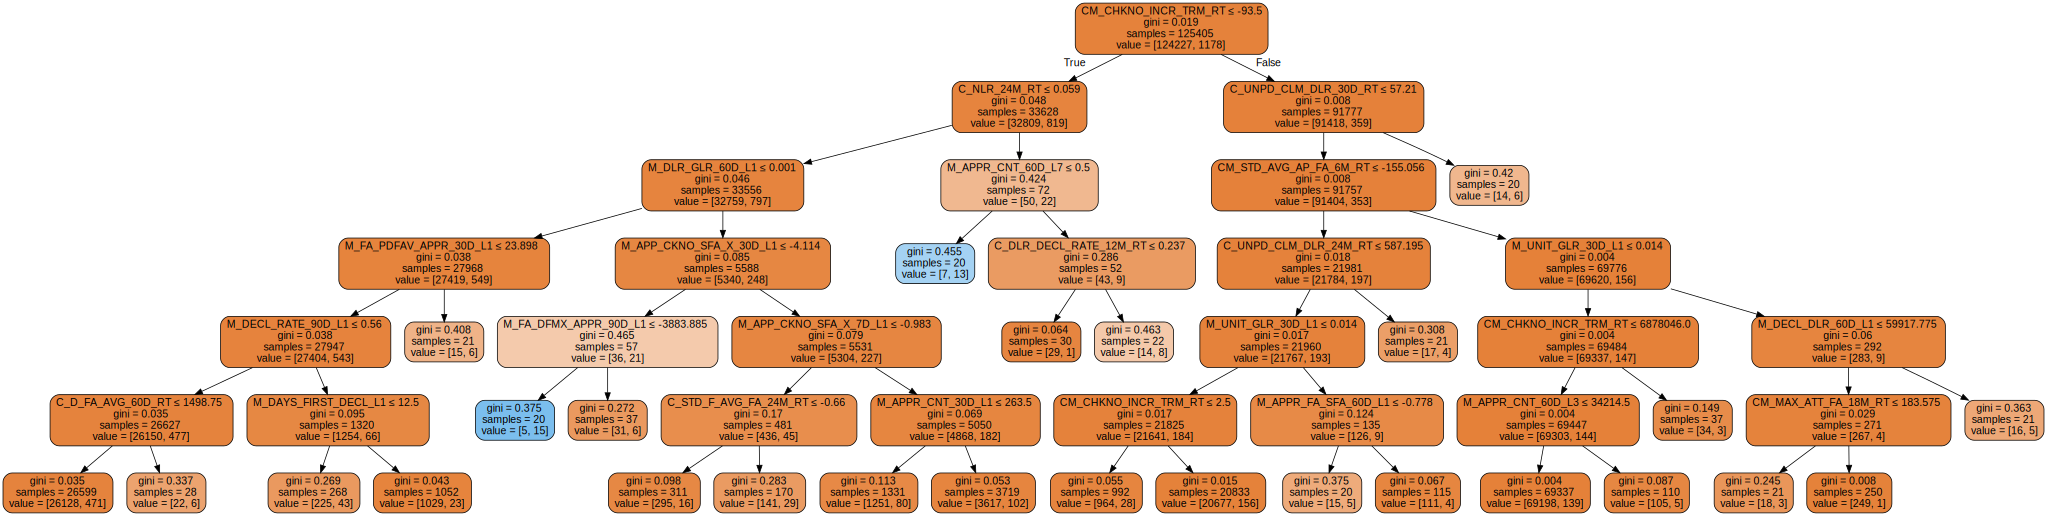

In [59]:
#initial tree
clf = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=6, min_samples_leaf=20)
clf = clf.fit(imputed_X_train,y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                    feature_names=pred_attr, 
                                    filled=True, 
                                    rounded=True, 
                                    special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [60]:
#calculate AUC values
clf_predictions_train = clf.predict(imputed_X_train)
clf_probs_train = clf.predict_proba(imputed_X_train)[:, 1]

clf_predictions_val = clf.predict(imputed_X_val)
clf_probs_val = clf.predict_proba(imputed_X_val)[:, 1]

# Calculate roc auc
clf_roc_value_train = roc_auc_score(y_train, clf_probs_train)
clf_roc_value_val = roc_auc_score(y_val, clf_probs_val)
print("Train AUC:{} Validate AUC:{}".format(clf_roc_value_train, clf_roc_value_val))

Train AUC:0.7928692460320632 Validate AUC:0.7478717263106052


In [61]:
#let's see if I can find an optimal tree depth to work with
import matplotlib.pyplot as plt
def tree_testing(depth,min_leaf):
    clf = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=depth, min_samples_leaf=min_leaf)
    clf = clf.fit(imputed_X_train,y_train)
    clf_probs_val = clf.predict_proba(imputed_X_val)[:, 1]
    return roc_auc_score(y_val, clf_probs_val)

tree_results_a = {}
for i in range(1,15):
    tree_results_a[i] = tree_testing(i,20)

tree_results_b = {}
for i in range(1,15):
    tree_results_b[i] = tree_testing(i,50)
    
tree_results_c = {}
for i in range(1,15):
    tree_results_c[i] = tree_testing(i,100)

In [62]:
#convert results dictionaries into numpy arrays and plot 
tree_results_a_df =  pd.DataFrame.from_dict(tree_results_a, orient='index', columns = ['MIN_LEAF_20'])
tree_results_b_df =  pd.DataFrame.from_dict(tree_results_b, orient='index', columns = ['MIN_LEAF_50'])
tree_results_c_df =  pd.DataFrame.from_dict(tree_results_c, orient='index', columns = ['MIN_LEAF_100'])

tree_results_agg = tree_results_a_df.join([tree_results_b_df,tree_results_c_df])

tree_results_agg

,MIN_LEAF_20,MIN_LEAF_50,MIN_LEAF_100
1,0.692374,0.692374,0.692374
2,0.696823,0.698475,0.698565
3,0.741830,0.743394,0.743313
4,0.745167,0.749240,0.749335
5,0.748171,0.749646,0.749886
6,0.747872,0.748948,0.751809
7,0.744893,0.752102,0.757757
8,0.736176,0.746127,0.750785
9,0.720213,0.725990,0.742754
10,0.697270,0.710870,0.726922


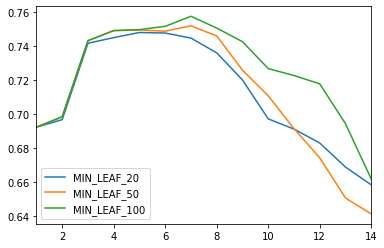

In [63]:
tree_results_agg.plot(y=["MIN_LEAF_20","MIN_LEAF_50","MIN_LEAF_100"], kind='line')

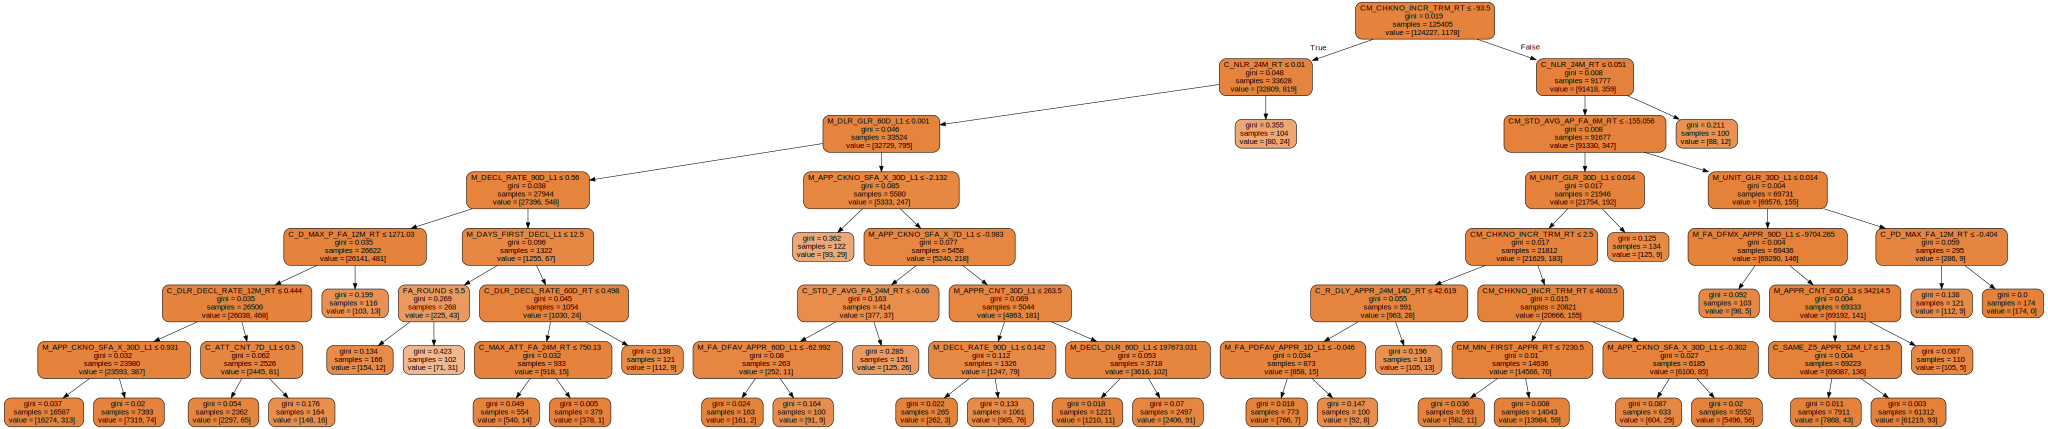

In [64]:
#tree is optimized with a depth of 7 and min leaf size is 100
#let's take a look at that tree
clf = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=7, min_samples_leaf=100)
clf = clf.fit(imputed_X_train,y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                    feature_names=pred_attr, 
                                    filled=True, 
                                    rounded=True, 
                                    special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [65]:
#compare the AUC for train and validate
clf_predictions_train = clf.predict(imputed_X_train)
clf_probs_train = clf.predict_proba(imputed_X_train)[:, 1]

clf_predictions_val = clf.predict(imputed_X_val)
clf_probs_val = clf.predict_proba(imputed_X_val)[:, 1]

# Calculate roc auc
clf_roc_value_train = roc_auc_score(y_train, clf_probs_train)
clf_roc_value_val = roc_auc_score(y_val, clf_probs_val)
print("Train AUC:{} Validate AUC:{}".format(clf_roc_value_train, clf_roc_value_val))

Train AUC:0.8236431306821077 Validate AUC:0.7577572801970762


In [72]:
#create data frame with txn_uid and score to export out for comparison with my SAS work 
probs_deep_dive = pd.DataFrame(clf.predict_proba(imputed_X_deep_dive)[:, 1], columns = ['TREE_PROB_DUP_PRES'])
score_log_df = pd.merge(analysis_df['TXN_UID'], probs_deep_dive, how='inner', left_index=True, right_index=True)
score_log_df

,TXN_UID,TREE_PROB_DUP_PRES
0,2705210000296,0.001517
1,2705210000299,0.001517
2,2705210000358,0.001517
3,2705210000366,0.018870
4,2705210000398,0.001517
...,...,...
307659,9006430014999,0.018870
307660,9006430015015,0.001517
307661,9006430015040,0.237705
307662,9006430015112,0.018870


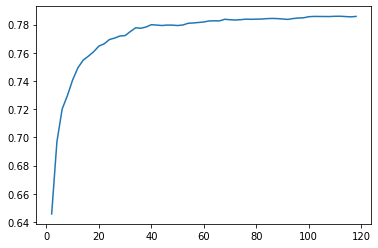

In [73]:
#now look into the lift I may get with a random forest
from sklearn.ensemble import RandomForestClassifier

def forest_testing(n_estimators):
    rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=100, random_state=100, bootstrap=True, max_features='sqrt')
    rf.fit(imputed_X_train, y_train);
    rf_probs_val = rf.predict_proba(imputed_X_val)[:, 1]
    return roc_auc_score(y_val, rf_probs_val)

forest_results = {}
for i in range(1,60):
    forest_results[i*2] = forest_testing(i*2)

plt.plot(list(forest_results.keys()), list(forest_results.values()))
plt.show()

In [75]:
#this really maxes out at 112: 0.7859289621318579, could go furhter but really not going to get much more
#fit this gain and take a look at AUC for train and validate
rf = RandomForestClassifier(n_estimators = 112, min_samples_split = 100, random_state = 100, bootstrap = True, max_features = 'sqrt')
rf.fit(imputed_X_train, y_train);

rf_probs_train = rf.predict_proba(imputed_X_train)[:, 1]
rf_probs_val = rf.predict_proba(imputed_X_val)[:, 1]

rf_roc_value_train = roc_auc_score(y_train, rf_probs_train)
rf_roc_value_val = roc_auc_score(y_val, rf_probs_val)
print("Train AUC:{} Validate AUC:{}".format(rf_roc_value_train, rf_roc_value_val))

Train AUC:0.9976546166929228 Validate AUC:0.7859289621318579


In [77]:
#Now see what is being found to be important for predictions
fi = pd.DataFrame({'feature': pred_attr,
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
# Export and Display
fi.to_excel("./Output/Feature Importance from Forest.xlsx", index = False)
fi.head(20)#create data frame with txn_uid and score to export out for comparison with my SAS work 


In [78]:
#now score the deep dive data set and log the probs
del probs_deep_dive
probs_deep_dive = pd.DataFrame(rf.predict_proba(imputed_X_deep_dive)[:, 1], columns = ['RF_PROB_DUP_PRES'])

score_log_df = pd.merge(score_log_df, probs_deep_dive, how='inner', left_index=True, right_index=True)
score_log_df

,TXN_UID,TREE_PROB_DUP_PRES,RF_PROB_DUP_PRES
0,2705210000296,0.001517,0.000293
1,2705210000299,0.001517,0.000000
2,2705210000358,0.001517,0.000953
3,2705210000366,0.018870,0.011076
4,2705210000398,0.001517,0.001095
...,...,...,...
307659,9006430014999,0.018870,0.030917
307660,9006430015015,0.001517,0.023146
307661,9006430015040,0.237705,0.277688
307662,9006430015112,0.018870,0.030553


In [85]:
#give XG boost a try
from xgboost import XGBClassifier 

xg_model = XGBClassifier(max_depth=100, learning_rate=0.05, n_estimators=1000, objective='binary:logistic', booster='gbtree')
xg_model.fit(imputed_X_train, y_train, 
             early_stopping_rounds=10, 
             eval_set=[(imputed_X_val, y_val)],
             verbose=False)

xg_pred = xg_model.predict_proba(imputed_X_val)[:,1]
roc_auc_score(y_val, xg_pred)

0.7811732884067613

In [88]:
xg_fi = pd.DataFrame({'feature': pred_attr,
                   'importance': xg_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
xg_fi.head()

,feature,importance
612,NAT_POSITIVE_GRADE_Z,0.086405
269,C_UNPD_CLM_DLR_60D_RT,0.018469
385,C_UNPD_CLM_DLR_18D_RT,0.007652
207,CM_STD_AVG_AP_FA_6M_RT,0.007322
324,CM_STD_AVG_FA_30D_RT,0.006931


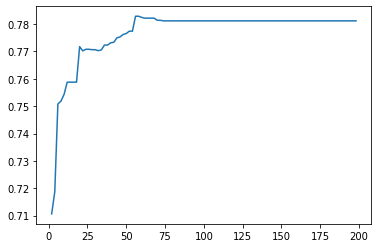

In [91]:
#now test out varying the number of estimators
def xgboost_testing(n_estimators,learning_rate):
    xg_model = XGBClassifier(max_depth = 50, learning_rate=learning_rate, n_estimators=n_estimators, objective='binary:logistic', booster='gbtree')
    xg_model.fit(imputed_X_train, y_train, 
             early_stopping_rounds=10, 
             eval_set=[(imputed_X_val, y_val)],
             verbose=False)
    xg_pred = xg_model.predict_proba(imputed_X_val)[:,1]
    return roc_auc_score(y_val, xg_pred)

xgboost_results = {}
for i in range(1,100):
    xgboost_results[i*2] = xgboost_testing(i*2,0.05)


plt.plot(list(xgboost_results.keys()), list(xgboost_results.values()))
plt.show()

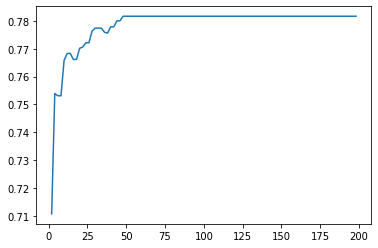

In [92]:
#now alter the learning rate to see how it compares
xgboost_results_b = {}
for i in range(1,100):
    xgboost_results_b[i*2] = xgboost_testing(i*2,0.1)

plt.plot(list(xgboost_results_b.keys()), list(xgboost_results_b.values()))
plt.show()

In [95]:
#will use 56 estimators with a learning rate of 0.05
xg_model = XGBClassifier(max_depth=50, learning_rate=0.05, n_estimators=56, objective='binary:logistic', booster='gbtree')
xg_model.fit(imputed_X_train, y_train, 
             early_stopping_rounds=10, 
             eval_set=[(imputed_X_val, y_val)],
             verbose=False)

xg_pred_train = xg_model.predict_proba(imputed_X_train)[:,1]
train_auc = roc_auc_score(y_train, xg_pred_train)
xg_pred_val = xg_model.predict_proba(imputed_X_val)[:,1]
val_auc = roc_auc_score(y_val, xg_pred_val)

print("Train AUC:{}, Val AUC:{}".format(train_auc,val_auc))

Train AUC:0.9798419845984614, Val AUC:0.7828597168747988


In [102]:
#pull out the feature importance
xg_fi = pd.DataFrame({'feature': pred_attr,
                   'importance': xg_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

xg_fi.to_excel("./Output/Feature Importance from XGBoost.xlsx", index = False)
xg_fi.head()

,feature,importance
612,NAT_POSITIVE_GRADE_Z,0.092547
269,C_UNPD_CLM_DLR_60D_RT,0.019765
47,CM_CHKNO_INCR_TRM_RT,0.009367
385,C_UNPD_CLM_DLR_18D_RT,0.008189
233,C_SAME_Z4_DECL_3M_RT,0.006439


In [97]:
#now score the deep dive data set and log the probs
del probs_deep_dive
probs_deep_dive = pd.DataFrame(xg_model.predict_proba(imputed_X_deep_dive)[:, 1], columns = ['XGB_PROB_DUP_PRES'])

score_log_df = pd.merge(score_log_df, probs_deep_dive, how='inner', left_index=True, right_index=True)
score_log_df

,TXN_UID,TREE_PROB_DUP_PRES,RF_PROB_DUP_PRES,XGB_PROB_DUP_PRES
0,2705210000296,0.001517,0.000293,0.030958
1,2705210000299,0.001517,0.000000,0.030962
2,2705210000358,0.001517,0.000953,0.030958
3,2705210000366,0.018870,0.011076,0.033356
4,2705210000398,0.001517,0.001095,0.030958
...,...,...,...,...
307659,9006430014999,0.018870,0.030917,0.036825
307660,9006430015015,0.001517,0.023146,0.034386
307661,9006430015040,0.237705,0.277688,0.380031
307662,9006430015112,0.018870,0.030553,0.051680


In [101]:
#export scores so that I can compare to the logistic regression model I completed in SAS
score_log_df.to_csv("./Output/dup pres scores from trees.csv", index = False)